#### RFM-analysis [mini-project]

Perform RFM-analysis. Divide each segment into four classes and find answers to the following questions:
* What was the max number of orders by one user?
* What is the upper Monetary value boundary for users to be classified as a class 4, subsegment M?
* What is the lower Frequency boundary for users to be classified as a class 1, subsegment F?
* What is the upper Recency boundary for users to be classified as a class 2, subsegment R?
* How many users do we have in a segment 111?
* How many users do we have in a segment 311?
* How many users do we have in the largest segmen?
* What segment does have the least amount of users?
* How many users do we have in the smallest segmen?

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading data from a zipped csv file
df = pd.read_csv('RFM_ht_data.zip', compression='zip',
                dtype={0: 'str', 1: 'str', 2: 'str', 3: 'float'})

df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [3]:
# checking general info (data types and missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [4]:
# converting date to a datetime data type
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)

In [5]:
# checking for min date
df.InvoiceDate.min()

Timestamp('2020-09-01 00:00:00')

In [6]:
# checking for max date
df.InvoiceDate.max()

Timestamp('2020-09-30 00:00:00')

In [7]:
# renaming columns for further convenience
df.rename(columns={'InvoiceNo': 'invoice',
                   'CustomerCode': 'customer',
                   'InvoiceDate': 'date',
                   'Amount': 'amount'}, inplace=True)

In [8]:
# difining the last date
last_date = df.date.max()

In [9]:
# building RFM table
rfm_table = df.groupby('customer', as_index=False) \
              .agg({'date': lambda x: (last_date - x.max()).days,  # Recency
                    'invoice': 'count',  # Frequency
                    'amount': 'sum'})  # Monetary value

rfm_table['date'] = rfm_table['date'].astype(int)

rfm_table.rename(columns={'date': 'recency',
                          'invoice': 'frequency',
                          'amount': 'monetary'}, 
                 inplace=True)

rfm_table

,customer,recency,frequency,monetary
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [10]:
# defining boundaries
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])

quantiles

,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [11]:
rfm_segmentation = rfm_table

In [12]:
# classification for Recency subsegment
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

# classification for Frequency and Monetary value subsegments
def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [13]:
# applying segmentation
rfm_segmentation['R_Quartile'] = rfm_segmentation['recency'].apply(RClass, args=('recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['frequency'].apply(FMClass, args=('frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['monetary'].apply(FMClass, args=('monetary',quantiles))

# creating segments
rfm_segmentation['RFMClass'] = rfm_segmentation.R_Quartile.map(str) \
                              + rfm_segmentation.F_Quartile.map(str) \
                              + rfm_segmentation.M_Quartile.map(str)

In [14]:
# crosstab for F and R subsegments
pd.crosstab(index=rfm_segmentation.R_Quartile, columns=rfm_segmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


In [15]:
# graphics in SVG format are more sharp an legible
%config InlineBackend.figure_format = 'svg'

# increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

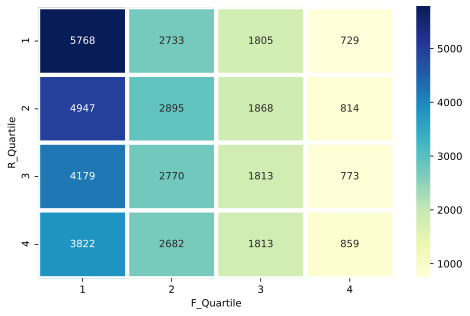

In [16]:
# building LTV heatmap
viz = rfm_segmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary', 
                        aggfunc=np.median).applymap(int)

sns.heatmap(viz, cmap="YlGnBu",
            annot=True,
            fmt=".0f",
            linewidths=4.15,
            annot_kws={"size": 10},
            xticklabels=1,
            yticklabels=1);

In [17]:
# BEST users sorted alphabetically
rfm_segmentation[rfm_segmentation['RFMClass'] == '111'].sort_index()

,customer,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
13,02213280,0,6,4772.93,1,1,1,111
18,02213315,0,4,13386.21,1,1,1,111
22,02213383,2,8,6283.81,1,1,1,111
28,02213478,0,4,6270.09,1,1,1,111
31,02213553,1,4,4737.87,1,1,1,111
...,...,...,...,...,...,...,...,...
123681,99099136,2,8,6341.23,1,1,1,111
123685,99099219,0,6,4084.83,1,1,1,111
123704,99099587,1,6,5375.69,1,1,1,111
123719,99099814,1,11,9610.69,1,1,1,111


In [18]:
# What was the max number of orders by one user?
rfm_table.frequency.max()

204

In [19]:
# What is the upper Monetary value boundary for users to be classified as a class 4, subsegment M?
quantiles['monetary'].values[0]

765.0

In [20]:
# What is the lower Frequency boundary for users to be classified as a class 1, subsegment F?
rfm_table[rfm_table['frequency'] > 3].sort_values('frequency').frequency.head(1).values[0]

4

In [21]:
# What is the upper Recency boundary for users to be classified as a class 2, subsegment R?
rfm_segmentation[rfm_segmentation['R_Quartile'] == 2] \
    .sort_values('recency', ascending=False) \
    .head(1).recency.max()

8

In [22]:
# How many users do we have in a segment 111?
rfm_segmentation[rfm_segmentation['RFMClass'] == '111'].shape[0]

9705

In [23]:
# How many users do we have in a segment 311?
rfm_segmentation[rfm_segmentation['RFMClass'] == '311'].shape[0]

1609

In [24]:
# How many users do we have in the largest segmen?
rfm_segmentation.groupby('RFMClass', as_index=False) \
    .agg({'customer': 'count'}) \
    .sort_values('customer', ascending=False) \
    .head(1).customer.max()

10624

In [25]:
# What segment does have the least amount of users?
rfm_segmentation.groupby('RFMClass', as_index=False) \
    .agg({'customer': 'count'}) \
    .sort_values('customer', ascending=True) \
    .head(1).RFMClass.values[0]

'414'

In [26]:
# How many users do we have in the smallest segmen?
rfm_segmentation.groupby('RFMClass', as_index=False) \
    .agg({'customer': 'count'}) \
    .sort_values('customer', ascending=True) \
    .head(1).customer.min()

2